# Time Series Homework

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

import math
import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

Loading BokehJS ...

## Problem 3

We will first read the two files given to us into dataframes that we can work with

In [21]:
ps_cpi = pd.read_csv("CPI.csv")
ps_cpi['date'] =pd.to_datetime(ps_cpi['date'])
ps_cpi.head(10)

,date,CPI
0,2008-07-24,100.0000
1,2008-07-25,100.0000
2,2008-07-26,100.0000
3,2008-07-27,100.0000
4,2008-07-28,100.0000
5,2008-07-29,100.0000
6,2008-07-30,100.0000
7,2008-07-31,100.0000
8,2008-08-01,100.5251
9,2008-08-02,100.5251


Notice that while data in the file on a daily basis, CPI only changes on a monthly basis. Hence, the monthly CPI can be obtained by taking the CPI of any day during a month. Additionally, we split the data into training and testing data sets as outlined in the problem statement

In [22]:
# cpi_monthly = pd.DataFrame(columns =['Month','CPI'])
ps_cpi['YearMonth'] = ps_cpi['date'].dt.strftime('%Y-%m')
cpi =ps_cpi.drop_duplicates('YearMonth', keep='last').copy().reset_index().drop(['index'],axis=1)
cpi_train = (cpi[cpi.YearMonth<'2013-09'].copy())
cpi_test = (cpi[cpi.YearMonth >='2013-09'].copy())
# cpi_train.CPI = np.log(cpi_train.CPI)
# cpi_test.CPI = np.log(cpi_test.CPI)
cpi.head(10)


,date,CPI,YearMonth
0,2008-07-31,100.00000,2008-07
1,2008-08-31,100.52510,2008-08
2,2008-09-30,100.12380,2008-09
3,2008-10-31,99.98538,2008-10
4,2008-11-30,98.97539,2008-11
5,2008-12-31,97.07973,2008-12
6,2009-01-31,96.07569,2009-01
7,2009-02-28,96.49385,2009-02
8,2009-03-31,96.97369,2009-03
9,2009-04-30,97.20951,2009-04


Visualize the time series

In [23]:
p = figure(plot_width=400, plot_height=400, title = "Monthly CPI")
p.line(cpi_train.index,cpi_train.CPI,line_color="navy",line_width =2.5)
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
show(p)


From the visualization, it is clear that the timeseries has a deterministic trend. We try and fit a linear model to the data (as in the question above) and see if this is sufficient to represent the trend. We then subtract this trend from the data.


In [24]:
model = LinearRegression().fit(np.array(cpi_train.index).reshape(-1, 1),cpi_train.CPI)
coefficients = [model.coef_[0],model.intercept_]
print("The linear trend is given by F(t) = " +str(coefficients[0])+"*t + (" +str(coefficients[1])+")")
linear_cpi =model.predict(np.array(cpi_train.index).reshape(-1, 1))
p = figure(plot_width=400, plot_height=400, title = "CPI Time Series")
p.line(cpi_train.index,cpi_train.CPI, line_color="navy", line_width=2, legend_label ="Original Data")
p.line(cpi_train.index,linear_cpi, line_color="orange",line_width=2.5,legend_label ="Linear Trend")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
p.legend.location='bottom_right'
show(p)

The linear trend is given by F(t) = 0.16104348366951224*t + (96.72932632872502)


We now subtract this linear trend from the data. When prompted to 'Choose Method:' in the following part, please type 'linear'

> $\textit{Note :}$ An alternative to detrending the data in this manner would be to take first difference. Economists tend to log transform the CPI data and then take the first difference in order to detrend it. While the problem set only asks for the linear trend to be removed from the data, the code below allows you to visualize what the first difference of log transform looks like as well. In order to see this, please enter "log" when asked to choose method. Please remember to run the block again with the method as linear to proceed with the next part of the PSET.

In [25]:
# x = input('Choose Method:')
x = 'linear'
if x == 'linear':
    remaining = cpi_train.CPI - linear_cpi
    linear_cpi_test = model.predict(np.array(cpi_test.index).reshape(-1, 1))
    remaining_test = cpi_test.CPI - linear_cpi_test
    test = cpi_test.index
    train = cpi_train.index
else:
    # detrend using log diff
    cpi_diff_log = np.log(cpi.CPI).diff()
    remaining = cpi_diff_log[0:cpi_train.shape[0]]
    remaining.iloc[0] = 0    
    #.reset_index()#.drop(['index'],axis =1)
    remaining_test = cpi_diff_log[cpi_train.shape[0]:].dropna()
    remaining_test.iloc[0] = 0
    test = cpi_test.index
    train = cpi_train.index


    
p = figure(plot_width=400, plot_height=400, title = "CPI Time Series")
p.line(train,remaining, line_color="navy", line_width=2, legend_label ="Detrended Data")



# p.line(cpi_diff.index,cpi_diff,line_color="green",line_width =2.5)
show(p)
print("the maximum residual value is:"+str(np.max(remaining)))

the maximum residual value is:3.634730187605456


Note that at some stage, we will be required to add back the trend to the data. The function $\texttt{rebuild}$ _ $\texttt{diffed()}$ below has been designed for this purpose. We will be calling this function later. 

In [26]:
def rebuild_diffed(series, first_element_original,x,linear_trend):
    if x == 'linear':
        final = series + linear_trend
    else:
        cumsum = pd.Series(series).cumsum()
        final = np.exp(cumsum.fillna(0) + first_element_original)
        if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))
    return final

As there seems to be no other trend present in this residual, we can take the linear trend to be sufficient and move to the next step, i.e. to deseasonalize the data. However, the above visualization seems to indicate no clear seasonality. Hence, we directly proceed to fitting an AR Model on the residual. To do so, we first plot the autocorrelation and partial autocorrelation plots.

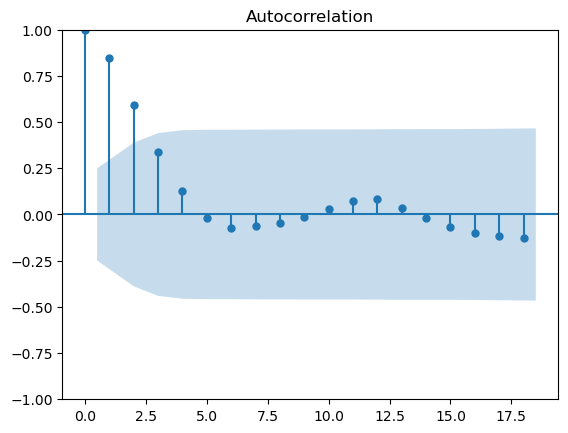

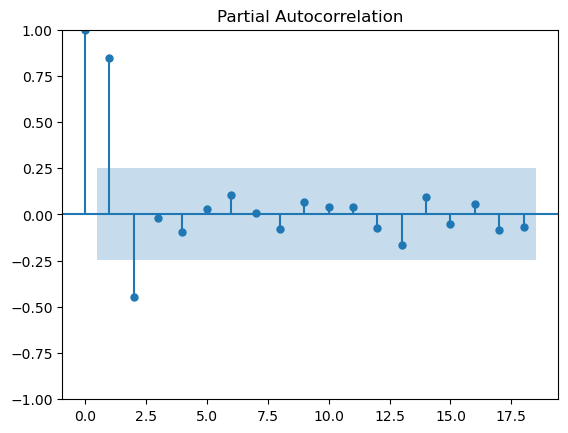

In [27]:
#linear
plot_acf(remaining)
plt.show()
plot_pacf(remaining)
plt.show()

From the above PACF plot, we can see that the highest lag at which the plot extends beyond the statistically significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data. However, we can further verify this by calculating the rmse of the fit

In [28]:
rmse_train=[]

for n in range(1,8):
    model = AutoReg(remaining, lags= n,trend='n')
    model_fit = model.fit()
    predictions=model_fit.predict()
    rmse=(mean_squared_error(remaining[n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

    
    
p = figure(plot_width=400, plot_height=400, title = "RMSE of AR Models of order n")
p.scatter(np.arange(1,8),rmse_train,size = 15, marker ="square", line_color="navy",fill_color="orange", fill_alpha =0.5, legend_label ="RMSE")
p.xaxis.axis_label ='n'
p.yaxis.axis_label ='RMSE'
p.legend.location='top_right'
show(p)




In [29]:
#plot RMSE for a range of lags p 
n = 2
rmse_ar=[]
for n in range(1,8):
    model = AutoReg(remaining, lags= n)
    model_fit = model.fit()
    coef = model_fit.params
    past = remaining[len(remaining)-n:].values
    past = [past[i] for i in range(len(past))]    
    test_predictions = list()
    for t in range(len(remaining_test.dropna())):
        length = len(past)
        lag = [past[i] for i in range(length-n,length)]
        pred = coef[0]
        for d in range(n):
            pred += coef[d+1] * lag[n-d-1]
        obs = remaining_test.values[t]
        test_predictions.append(pred)
        past.append(obs)
    rmse = (mean_squared_error(remaining_test.dropna(), test_predictions))**0.5
    rmse_ar.append(rmse)
    print('Test RMSE for AR(' + str(n) +'):' + str(rmse))

p = figure(plot_width=400, plot_height=400, title = "RMSE of AR Models of order n")
p.scatter(np.arange(1,8),rmse_ar,size = 15, marker ="square", line_color="navy",fill_color="orange", fill_alpha =0.5, legend_label ="RMSE")
p.xaxis.axis_label ='n'
p.yaxis.axis_label ='RMSE'
p.legend.location='bottom_right'
show(p)

Test RMSE for AR(1):0.3718449350821093
Test RMSE for AR(2):0.3932806013808887
Test RMSE for AR(3):0.37849552729362945
Test RMSE for AR(4):0.4425197971923714
Test RMSE for AR(5):0.43456315263365164
Test RMSE for AR(6):0.34020763928627823
Test RMSE for AR(7):0.31251327073280694


The plot above seems to indicate the AR(1) model predictions have the least rmse. While it would have been ideal to have our previous conclusion of model order 2 validated by the RMSE, we should note this kind of discrepancy between the two diagnostic methods (rmse and PACF) can occur when working with finite data sets. In order to proceed, we choose to work with model order of 2 so we do not miss out on possible lag terms.

In [30]:
## Building AR (2) Model 
n = 2
AR2_model = AutoReg(remaining, lags= n).fit()# Here we have used the default value for the trend parameter
coef = AR2_model.params
print(coef)

# walk forward over time steps in test
past = remaining[len(remaining)-n:].values
past = [past[i] for i in range(len(past))]
test_predictions = list()
training_predictions = AR2_model.predict(start = train[0], end =train[-1])
for t in range(len(remaining_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = remaining_test.values[t]
    test_predictions.append(pred)
    past.append(obs)
final_training = (rebuild_diffed(training_predictions,np.log(cpi_train.CPI[0]),x,linear_cpi))
final_test = (rebuild_diffed(test_predictions,np.log(cpi_train.iloc[-1].CPI),x,linear_cpi_test))



const    -0.043105
CPI.L1    1.323666
CPI.L2   -0.530797
dtype: float64


We now plot the final model predictions and the actual observed data together to visualize the fit.

In [31]:
p = figure(plot_width=800, plot_height=400, title = "CPI predictions")
p.line(cpi_train.index,cpi_train.CPI,line_width =2.5, line_color="black", line_dash="dashed", legend_label ="Training Data")
p.line(cpi_test.index,cpi_test.CPI,line_width =2.5, line_color="green", line_dash="dashed", legend_label ="Test Data")
p.line(cpi_train.index,final_training,line_color="red",line_width=2.5,legend_label ="Final AR(2) Model (Training Data Fit)")
p.line(cpi_test.index,final_test,line_color="orange",line_width=2.5,legend_label ="Final AR(2) Model Predictions")


p.legend.location = "bottom_right"
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'

show(p)


We see that the AR(2) Model does predict pretty well and the mean squared prediction error is small. We can also reaffirm this conclusion by plotting the residuals after the AR(2) predictions are subtracted from the detrended data 

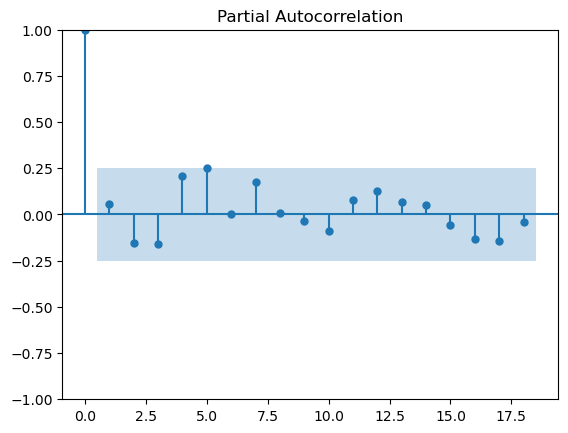

In [32]:
residuals = (remaining - training_predictions)[2:]
plot_pacf(residuals)
plt.show()

In [33]:
rmse = mean_squared_error(cpi_test.dropna().CPI,final_test[:-2])**0.5
print("The rmse of the final fit is " + str(rmse))

The rmse of the final fit is 0.39328060138088855


We see that the fit has a low rmse, considering that the order of the data is $10^2$.

**Inflation Rate**
In the next part of the question, since we will be working with external regressors that have different units(such as BER), we must first convert all the data into an equivalent form, i.e monthly inflation rates. We will first do so for CPI from which inflation rates can be simply calculated as
> $IR_t = \frac{CPI_t -CPI_{t-1}}{CPI_{t-1}}$

In [34]:
def calc_inflation_rate(data):
    ir = []
    for i in range(1,len(data)):
        ir_temp = (data[i]-data[i-1])/data[i-1] *100      
        ir.append(ir_temp)
#         print(i)
    return ir

In [35]:
#calculate monthly inflation from CPI
val = calc_inflation_rate(cpi.CPI.values)
val2=np.log(cpi.CPI).diff().values*100

cpi.loc[1:, 'IR_cpi'] = val
cpi['diff_log'] = val2

cpi_ir_train = (cpi[cpi.YearMonth<'2013-09'].copy())
cpi_ir_test = (cpi[cpi.YearMonth >='2013-09'].copy())

print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['IR_cpi'] + " %")
print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['diff_log'] + " %")


The inflation rate from CPI for the month of February in 2013 was 0.295722930 %
The inflation rate from CPI for the month of February in 2013 was 0.295286530 %


C:\Users\david\AppData\Local\Temp\ipykernel_1604\721024633.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['IR_cpi'] + " %")
C:\Users\david\AppData\Local\Temp\ipykernel_1604\721024633.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['diff_log'] + " %")


In [36]:
p = figure(plot_width=400, plot_height=400, title = "Monthly IR from CPI (in %)")
p.line(cpi_diff_log.index,cpi['diff_log'],line_color="navy",line_width =2.5)
p.line(cpi['IR_cpi'].index,cpi['IR_cpi'],line_color="orange",line_width =2.5)
# p.line(cpi_diff.index,cpi_diff,line_color="green",line_width =2.5)
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='Diff Ratio CPI'
show(p)



NameError: name 'cpi_diff_log' is not defined

Now we move on to converting BER to monthly inflation rates. Note that BER is reported on a daily basis. We first choose a monthly representative value by averaging the BER across all days of the month. BER is already a rate, however it is reported across a 10 year period. In order to convert this to a monthly value, we must then deannualize it using the following formula.
> $BER_t = (BER_t +1)^\frac{1}{12} -1$

In [127]:
ber = pd.read_csv('T10YIE.csv')
ber['DATE'] =pd.to_datetime(ber['DATE'])
ber['YearMonth'] = ber['DATE'].dt.strftime('%Y-%m')
ber = ber.drop(ber[ber.YearMonth< '2008-07'].index)
ber = ber.dropna()
#print(ber)

ber_monthly = pd.DataFrame(columns =['YearMonth','BER'])
ber_monthly['BER'] =ber.groupby('YearMonth').T10YIE.mean().values
ber_monthly['YearMonth'] = cpi.YearMonth
ber_monthly.drop([0])

#print(ber_monthly)
ber_ir_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_ir_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())


ber_ir_train['IR_ber'] = ((ber_ir_train.BER.values/100+1)**(1/12)-1)*100
ber_ir_test['IR_ber'] = ((ber_ir_test.BER.values/100+1)**(1/12)-1)*100
print("The inflation rate from BER for the month of February in 2013 was %0.9f" % ber_ir_train[ber_ir_train.YearMonth == '2013-02']['IR_ber'].values + " %")

The inflation rate from BER for the month of February in 2013 was 0.210441852 %


In [ ]:
cpi.describe()

In [ ]:
cpi.head()

,date,CPI,YearMonth,IR_cpi,diff_log
0,2008-07-31,100.00000,2008-07,NaN,NaN
1,2008-08-31,100.52510,2008-08,0.525100,0.523726
2,2008-09-30,100.12380,2008-09,-0.399204,-0.400003
3,2008-10-31,99.98538,2008-10,-0.138249,-0.138344
4,2008-11-30,98.97539,2008-11,-1.010138,-1.015274


Text(0, 0.5, 'CPI IR %')

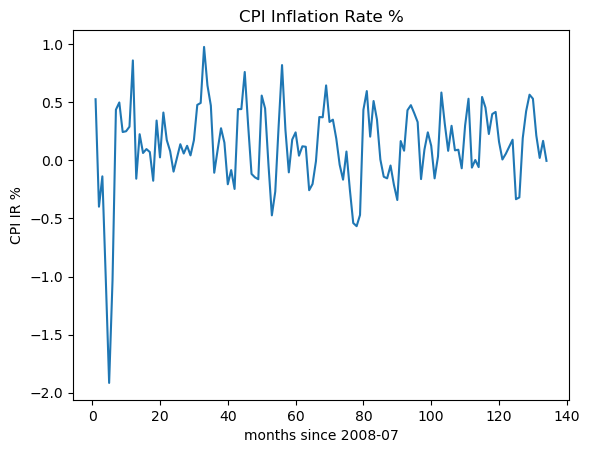

In [19]:
plt.plot(cpi.index.values, cpi.IR_cpi.values)
plt.title('CPI Inflation Rate %')
plt.xlabel('months since 2008-07')
plt.ylabel('CPI IR %')

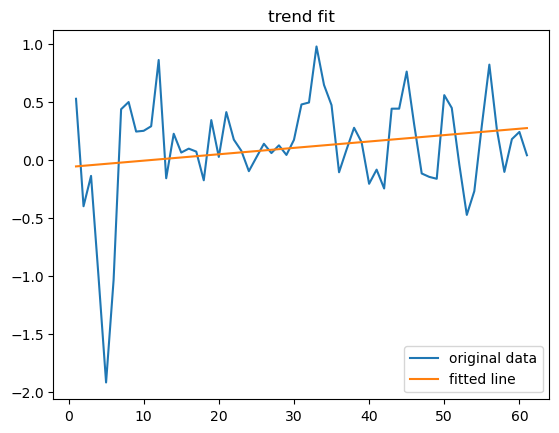

intercept [-0.06205584] coef [[0.0054937]]


Text(0.5, 1.0, 'trend fit residuals')

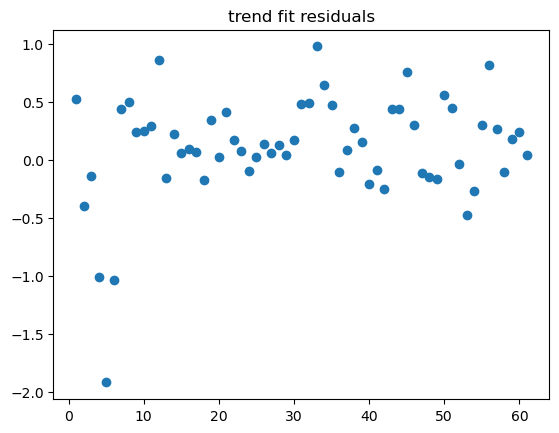

In [119]:
# fit quadratic
poly = PolynomialFeatures(1)
#  create x and x^2 col's
x_train_all = np.reshape(cpi_ir_train.index.values, [-1,1])
y_train_all = np.reshape(cpi_ir_train.IR_cpi.values, [-1,1])
x_train = x_train_all[1:]
y_train = y_train_all[1:] # first IR_cpi entry is nan so skip first
xx2_train = poly.fit_transform(x_train)
xx2_train = xx2_train[:,1:]  # remove 1st col since it is all 1's
linReg = LinearRegression().fit(xx2_train, y_train)
linReg = LinearRegression().fit(x_train, y_train)

y_quad_train = linReg.predict(x_train)
plt.plot(x_train[:,0], y_train[:,0], label='original data')
plt.plot(x_train[:,0], y_quad_train[:,0], label='fitted line')
plt.legend()
plt.title('trend fit')
plt.show()
print(f'intercept {linReg.intercept_} coef {linReg.coef_}')
# residuals_quad_train = y_quad_train[:,0] - y_train[:,0]
residuals_quad_train = y_train[:,0]
plt.scatter(x_train[:,0], residuals_quad_train)
plt.title('trend fit residuals')

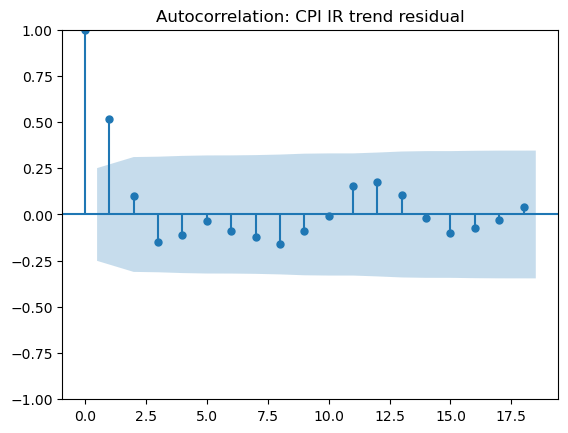

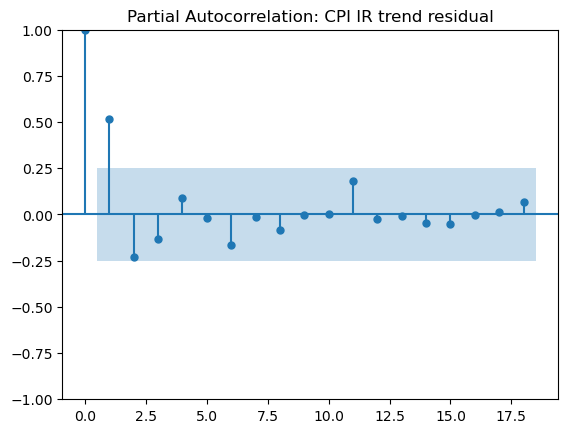

In [120]:
plot_acf(residuals_quad_train)
plt.title('Autocorrelation: CPI IR trend residual')
plt.show()
plot_pacf(residuals_quad_train)
plt.title('Partial Autocorrelation: CPI IR trend residual')
plt.show()

Use Lag 1 since higest PACF lag outside error region is 1

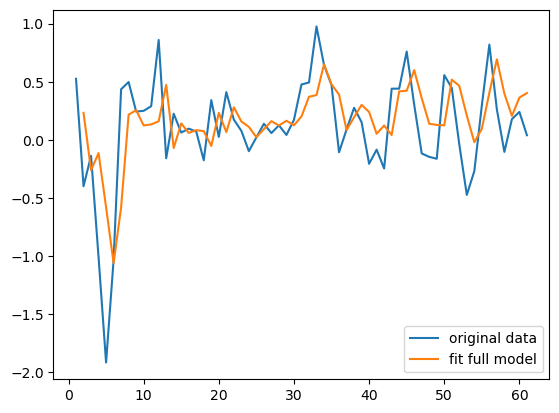

In [121]:
ar_model_fit = AutoReg(residuals_quad_train, lags= 1,trend='n').fit()
predictions_ar_model = ar_model_fit.predict()
# check ar model across training data
x_train_skip2 = x_train[:,0] # skip first 2 since ar model
y_train_skip2 = y_train[:,0]
y_quad_train_skip2 = y_quad_train[:,0]
y_train_pred_quadAndAr = y_quad_train_skip2 + predictions_ar_model
plt.plot(x_train_skip2, y_train_skip2, label='original data')
plt.plot(x_train_skip2, y_train_pred_quadAndAr, label='fit full model')
plt.legend()

In [107]:
len(y_train)

61

Text(0.5, 1.0, 'model(quad trend + AR)')

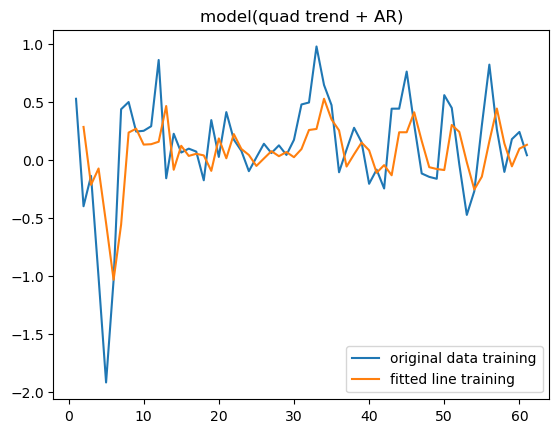

In [122]:
# alpha0 = linReg.intercept_[0]
# alpha1 = linReg.coef_[0,0]
alpha0 = 0
alpha1 = 0
# alpha2 = linReg.coef_[0,1]
alpha2 = 0
# AR model params
# const = model.params[0]
phi1 = ar_model_fit.params[0]

# generate predictions across full training data set to check model

x_train_1d = x_train[:,0] # len 61
y_train_1d = y_train[:,0] #
n_train = len(x_train)
residuals_quad_train_1d = residuals_quad_train # len 61

preds_train = np.repeat(np.nan, n_train) # fill in first 1 with something since don't predict first 

for i in range(0, n_train):
    # skip first  (start at 1) since AR model needs access to previous 1
    if i < 1:
        continue
    t = x_train_1d[i]
    # big X(t-1)  for AR
    X_t_1 = residuals_quad_train[i-1]
    # model ( quad trend + AR )
    pred_t = alpha0 + alpha1 * t + alpha2 * t**2 + phi1 * X_t_1
        
    preds_train[i] = pred_t


plt.plot(x_train_1d, y_train_1d, label='original data training')
plt.plot(x_train_1d, preds_train, label='fitted line training')
plt.legend()
plt.title('model(quad trend + AR)')

 rms nan


Text(0.5, 1.0, 'Forecast final model (AR, no trend)')

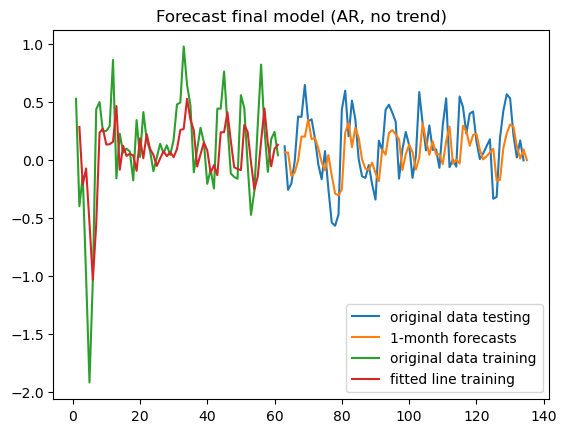

In [124]:
# 1 month forecasts for rest of data (after training data)
# 
cpi_ir_all = pd.concat([cpi_ir_train, cpi_ir_test], axis=0)

# start index of validation data is after training
startIdx = len(cpi_ir_train) + 1
endIdx = len(cpi_ir_all)
squ_err_arr = np.array([])
pred_t_fore = np.array([])
x_fore = np.array([])
y_fore = np.array([])
for mi in range(startIdx, endIdx):
    y = cpi_ir_all.IR_cpi[mi]
    y_t_1 = cpi_ir_all.IR_cpi[mi-1]
    pred_quad_t_1 = alpha0 + alpha1 * (mi-1) + alpha2 * (mi-1)**2
    # pred_quad_t_1 = alpha0 + alpha1 * (mi-1) 
    # need previous month's quad residual
    # quad_resid_t_1 = pred_quad_t_1 - y_t_1

    quad_resid_t_1 =  y_t_1

    pred_t = alpha0 + alpha1 * mi + alpha2 * mi**2 + phi1 * quad_resid_t_1
    # pred_t = alpha0 + alpha1 * mi + alpha2 * mi**2 
    # pred_t =  phi1 * quad_resid_t_1

    squ_err = (y - pred_t) ** 2
    squ_err_arr = np.append(squ_err_arr, squ_err)
    x_fore = np.append(x_fore, mi)
    y_fore = np.append(y_fore, y)
    pred_t_fore = np.append(pred_t_fore, pred_t)

rms = squ_err_arr.mean() ** .5
print(f' rms {rms}')

plt.plot(x_fore, y_fore, label="original data testing")
plt.plot(x_fore,pred_t_fore, label="1-month forecasts")
plt.plot(x_train_1d, y_train_1d, label='original data training')
plt.plot(x_train_1d, preds_train, label='fitted line training')
plt.legend()
plt.title('Forecast final model (AR, no trend)')

In [ ]:
cpi_ir_all.IR_cpi[137]

Text(0.5, 1.0, '% Inflation Rate from BER, CPI, and model forecast')

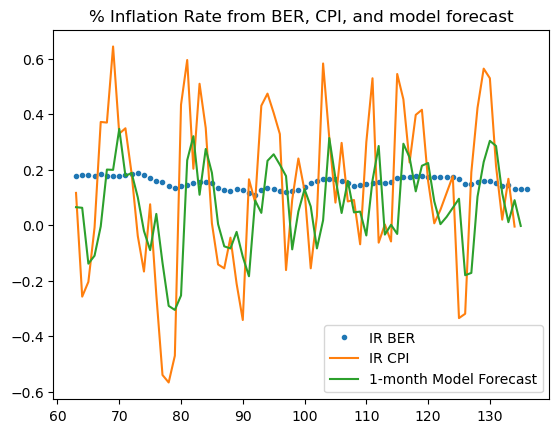

In [135]:
ber_ir_test.IR_ber # len 75
plt.plot(x_fore, ber_ir_test.IR_ber.values[:-1], '.', label='IR BER')
plt.plot(x_fore, y_fore, label='IR CPI')
plt.plot(x_fore, pred_t_fore, label='1-month Model Forecast')
plt.legend()
plt.title('% Inflation Rate from BER, CPI, and model forecast')

In [138]:
cpi_ir_train.iloc[-3:]

,date,CPI,YearMonth,IR_cpi,diff_log
59,2013-06-30,106.4575,2013-06,0.178040,0.177882
60,2013-07-31,106.7130,2013-07,0.240002,0.239714
61,2013-08-31,106.7551,2013-08,0.039452,0.039444


In [139]:
ber_ir_train.iloc[-3:]

,YearMonth,BER,IR_ber
59,2013-06,2.048500,0.169126
60,2013-07,2.122273,0.175159
61,2013-08,2.184545,0.180248


In [143]:
plt.xcorr(cpi_ir_train.IR_cpi.values[1:], ber_ir_train.IR_ber.values[1:])
# cpi_ir_train.IR_cpi.values
# ber_ir_train.IR_ber.values

array([0.20098306, 0.18228824, 0.15174302, 0.08805712, 0.05303945,
       0.02050716, 0.05031884, 0.09268396, 0.09207021, 0.11259377,
       0.13039411, 0.15365687, 0.14381903, 0.14986957, 0.14549669,
       0.15732205, 0.17557527, 0.18358938, 0.19444213, 0.18739849,
       0.18307288, 0.19342145, 0.17440071, 0.16084221, 0.14635581,
       0.13867229, 0.14373914, 0.16638556, 0.1730926 , 0.18533395,
       0.19240905, 0.19281055, 0.20194474, 0.21343493, 0.19701771,
       0.18533395, 0.19616141, 0.17888171, 0.156776  , 0.16237534,
       0.16614009, 0.16593747, 0.17125274, 0.18330724, 0.19082533,
       0.1869545 , 0.17697923, 0.17520651, 0.17567361, 0.18672969,
       0.20079391, 0.20555688, 0.19999374, 0.20406892, 0.20788436,
       0.21044185, 0.20944537, 0.19875971, 0.18830267, 0.16912623,
       0.17515874, 0.18024777])